In [1]:
# ───────────── Imports ─────────────
import kagglehub
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2

from ultralytics import YOLO
from tqdm.notebook import tqdm


In [2]:
# ─────────── 1) Descargar Dataset ───────────
path        = kagglehub.dataset_download("mstjebashazida/affectnet")
archive_dir = Path(path) / "archive (3)"
train_dir   = archive_dir / "Train"
test_dir    = archive_dir / "Test"

In [3]:
# ─────────── 2) Cargar y mapear etiquetas ───────────
labels_df = pd.read_csv(archive_dir / "labels.csv")
emotion_map = {
    0: "anger",   1: "contempt", 2: "disgust", 3: "fear",
    4: "happy",   5: "neutral", 6: "sad",     7: "surprise"
}
label2idx = {v: k for k, v in emotion_map.items()}
labels_df["label_idx"] = labels_df["label"].map(label2idx)

In [4]:
labels_df

,Unnamed: 0,pth,label,relFCs,label_idx
0,0,anger/image0000006.jpg,surprise,0.873142,7
1,1,anger/image0000060.jpg,anger,0.852311,0
2,2,anger/image0000061.jpg,anger,0.800957,0
3,3,anger/image0000066.jpg,disgust,0.843079,2
4,4,anger/image0000106.jpg,anger,0.849108,0
...,...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263,7
28171,28171,surprise/image0034961.jpg,surprise,0.738646,7
28172,28172,surprise/image0034966.jpg,surprise,0.774524,7
28173,28173,surprise/image0034973.jpg,neutral,0.766952,5


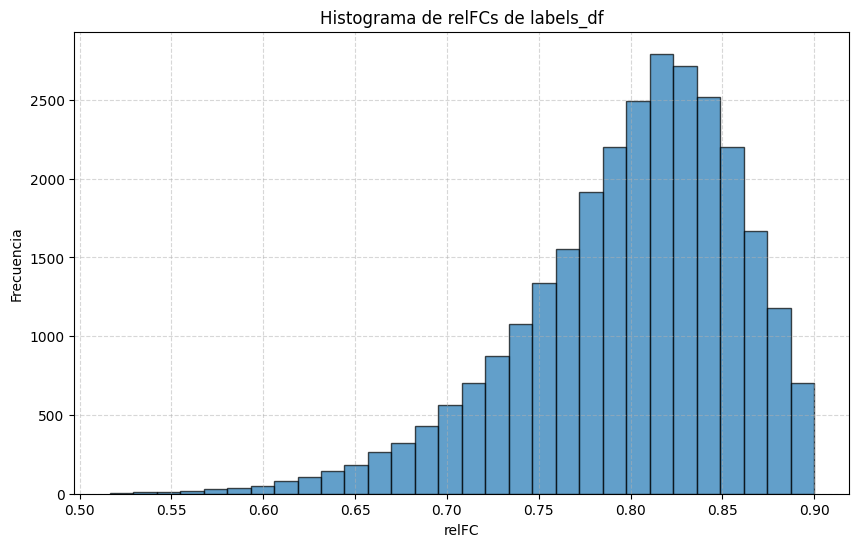

In [5]:
import matplotlib.pyplot as plt

# Asumiendo que labels_df ya está definido y contiene la columna 'relFCs'
plt.figure(figsize=(10, 6))
plt.hist(labels_df['relFCs'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('relFC')
plt.ylabel('Frecuencia')
plt.title('Histograma de relFCs de labels_df')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [6]:
# 1) Filtrar solo los relFCs > 0.8
high_relFCs = labels_df[labels_df['relFCs'] > 0.8]

# 2) Contar cuántas imágenes hay
n_high = len(high_relFCs)
print(f"Número de imágenes con relFC > 0.8: {n_high}")

Número de imágenes con relFC > 0.8: 15840


* Tenemos 8 emociones: anger, contempt, disgust, fear, happy, neutral, sad, surprise
* Tenemos un indice de confianza de la emocion por imagen. Solo se usara la que tenga mayor al 90%